## Importamos las bibliotecas

In [1]:
import cv2
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage import data, segmentation, color, measure, io
from skimage.future import graph
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Funciones mas ocupadas

In [2]:
def read_img(url, grey=False):
    """
    Metodo que carga la imagen.
    Parameters
    ----------
    url : string 
        ruta donde se encuentra la imagen.
    grey : boolean
        valor que indica si se lee la imagen a color o en blanco y negro
    Returns
    ----------
    Retorna la imagen en formato RGB
    """
    image = cv2.imread(url,cv2.IMREAD_UNCHANGED)#cv2.IMREAD_UNCHANGED
    if grey:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)# COLOR_BGR2GRAY/COLOR_BGR2RGB
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_semgents(img,lambd):
    """
    Metodo que convierte los valores de las imagens a valores inicados en el lambda para las secciones obtenidas.
    Parameters
    ----------
    img : string 
        imagen a procesar.
    lambd : funcion lambda
        funcion de lambda ocupada para la seleccion de los segmentos.
    Returns
    ----------
    La matriz con los los segmentos de la imagen.
    """
    stagg_func_K = lambd
    vfunc = np.vectorize(stagg_func_K,otypes=[np.uint8])
    return vfunc(img)

## Lectura Imagen de prueba
Lectura de la imagen de prueba, se lee en blanco y negro para mejores resultados se algunos segmentadores

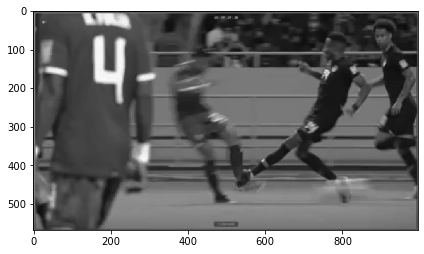

In [16]:
test = read_img("./dataset/VAR1.PNG",grey=True)
io.imshow(test)

# Segmentacion
## Segmentacion con K-means

- K: cantidad de segmentos a obtener, en nuesto caso 2, fondo y personas 
- attemps: cantidad de pasos 

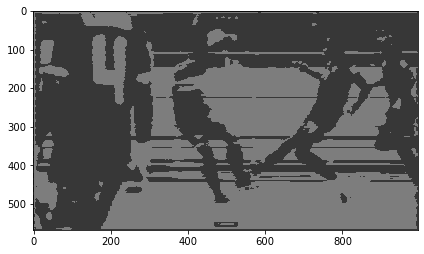

In [21]:
twoDimage = test.reshape((-1,3))
twoDimage = np.float32(twoDimage)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10

ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_KM = res.reshape((test.shape))
io.imshow(result_KM)

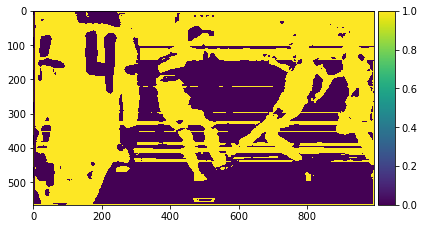

In [5]:
y = lambda p: 1 if p < 100 else 0
segment_kmeans = get_semgents(result_KM,y)
io.imshow(segment_kmeans)

## Split and Merge
- Se realiza una operacion de apertura a la imagen para eliminar los detalles mas pequeños y que no afecten directamente la segmentacion.

In [26]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(test, cv2.MORPH_OPEN, kernel, iterations=2)

In [29]:
def split(img, h0, w0, h, w) :
    """
    Metodo que realiza los splits en la imagen.
    Parameters
    ----------
    img : imagen  
        Matriz de la imagen a dividir.
    h0 : int
        Posicion inicial del eje y la division.
    w0 : int
        Posicion inicial del eje x de la division.
    h : int
        Posicion final del eje y de la division.
    w : int
        Posicion final del eje w de la division.
    Returns
    ----------
    True en caso de cumplida la validacion de la semejansa de los pixeles.
    """
    area = img[h0 : h0 + h, w0 : w0 + w]
    mean = np.mean(area)
    std = np.std(area, ddof = 1)

    total_points = 0
    operated_points = 0

    for row in range(area.shape[0]) :
        for col in range(area.shape[1]) :
            if (area[row][col] - mean) < 2 * std :
                operated_points += 1
            total_points += 1

    return (operated_points / total_points) >= 0.95

def merge(img, h0, w0, h, w) :
    """
    Metodo que realiza los merge en la imagen.
    Parameters
    ----------
    img : imagen  
        Matriz de la imagen a dividir.
    h0 : int
        Posicion inicial del eje y la division.
    w0 : int
        Posicion inicial del eje x de la division.
    h : int
        Posicion final del eje y de la division.
    w : int
        Posicion final del eje w de la division.
    Returns
    ----------
    None
    """
    for row in range(h0, h0 + h) :
        for col in range(w0, w0 + w) :
            if img[row, col] > 100 and img[row, col] < 200:
                img[row, col] = 0
            else :
                img[row, col] = 255

def recursion(img, h0, w0, h, w, similitud) :
    """
    Metodo que divide la imagen.
    Parameters
    ----------
    img : imagen  
        Matriz de la imagen a dividir.
    h0 : int
        Posicion inicial del eje y la division.
    w0 : int
        Posicion inicial del eje x de la division.
    h : int
        Posicion final del eje y de la division.
    w : int
        Posicion final del eje w de la division.
    similitud : int
        valor de similitud entre los minimos de h y w.
    Returns
    ----------
    None
    """
    if not split(img, h0, w0, h, w) and min(h, w) > similitud :
        split(img, h0, w0, int(h0 / 2), int(w0 / 2))
        split(img, h0, w0 + int(w0 / 2), int(h0 / 2), int(w0 / 2))
        split(img, h0 + int(h0 / 2), w0, int(h0 / 2), int(w0 / 2))
        split(img, h0 + int(h0 / 2), w0 + int(w0 / 2), int(h0 / 2), int(w0 / 2))
    else :
        merge(img, h0, w0, h, w)

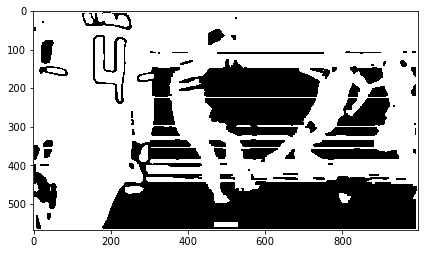

In [30]:
segemented_SyM = opening.copy()
recursion(segemented_SyM, 0, 0, segemented_SyM.shape[0], segemented_SyM.shape[1], 5)
io.imshow(segemented_SyM)

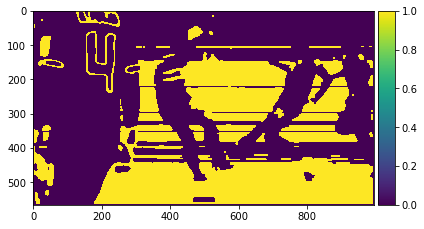

In [9]:
y = lambda p: 1 if p < 100 else 0
segment_SyM = get_semgents(segemented_SyM,y)
io.imshow(segment_SyM)

## Normalized_Cut_V2 

- Se realiza la operacion de Normalized_Cut_V2 a la imagen a color.
- Se evalua las segmentaciones con 2 convinaciones de valores distintos para mostrar la degradacion de la imagen con los resultados.
    - El primer caso de con 300 segmentos y reduccion a 210 cortes
    - El primer caso de con 75 segmentos y reduccion a 45 cortes
    

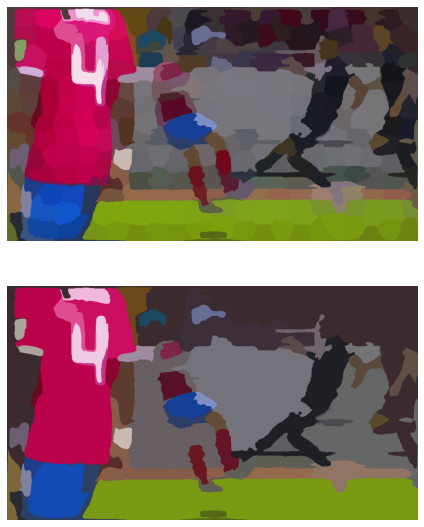

In [11]:
img = read_img("./dataset/VAR1.PNG")
labels = segmentation.slic(img, compactness=20, sigma=1, n_segments=300)
im_seg = color.label2rgb(labels, img, kind='avg')

g = graph.rag_mean_color(img, labels, mode='similarity')
labels_norm = graph.cut_normalized(labels, g, num_cuts=210)
im_norm = color.label2rgb(labels_norm, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(im_seg.astype(np.uint8))
ax[1].imshow(im_norm.astype(np.uint8))

for a in ax:
    a.axis('off')

plt.tight_layout()

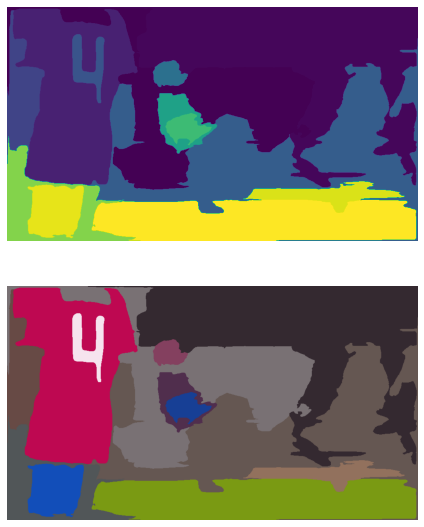

In [10]:
img = read_img("../datasets/imgs-falta/VAR1.PNG")
labels = segmentation.slic(img, compactness=20, sigma=1, n_segments=75) 
im_seg = color.label2rgb(labels, img, kind='avg')

g = graph.rag_mean_color(img, labels, mode='similarity')
labels_norm = graph.cut_normalized(labels, g, num_cuts=45)
im_norm = color.label2rgb(labels_norm, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(labels_norm.astype(np.uint8))
ax[1].imshow(im_norm.astype(np.uint8))

for a in ax:
    a.axis('off')

plt.tight_layout()

# Comparación
## Comparación Ground Truth

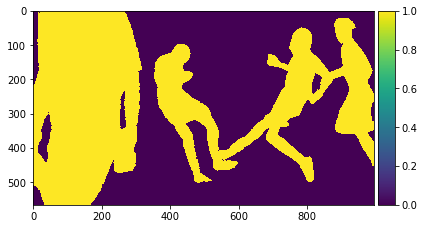

In [12]:
gt_1 = read_img("./dataset/GT1.png",grey=False)[:,:,0]
stagg_func = lambda p: 1 if p < 100 or p >150 else 0
vfunc = np.vectorize(stagg_func,otypes=[np.uint8])
GT1 = vfunc(gt_1)
io.imshow(GT1)

In [13]:
def get_metrics(img,gt):
    h,w = gt.shape
    tp,tn,fp,fn = 0,0,0,0
    for i in range(h):
        for j in range(w):
            if img[i,j] == gt[i,j]:
                if gt[i,j] == 0:
                    tn = tn+1
                else:
                    tp = tp+1 
            else:
                if gt[i,j] == 0:
                    fp = fp+1
                else:
                    fn = fn+1 
    d = {'0': [tn, fn], '1': [fp, tp]}
    df = pd.DataFrame(data=d)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    acurracy= (tp+tn)/(tp+tn+fn+fp)
    f1 = (2*tp)/(2*tp+fp+fn)
    return df, acurracy, precision, recall, f1

### Evaluacion de resultados Kmeans

In [14]:
df, acurracy, precision, recall, f1 =get_metrics(segment_kmeans,GT1)
display(df)
print("recall: ",recall)
print("precision: ",precision)
print("acurracy: ",acurracy)
print("f1:",f1)

0       1
0  201579  110902
1   49950  201734

recall:  0.8015368477932646
precision:  0.6452679793753758
acurracy:  0.7148848297927025
f1: 0.7149631414800114


### Evaluacion de resultados Split and Merge

In [15]:
df, acurracy, precision, recall, f1 =get_metrics(segment_SyM,GT1)
display(df)
print("recall: ",recall)
print("precision: ",precision)
print("acurracy: ",acurracy)
print("f1:",f1)

0       1
0  133292  179189
1  224147   27537

recall:  0.10941100745379126
precision:  0.13320530557356114
acurracy:  0.2850744019923249
f1: 0.12014135817281472


### Evaluacion de resultados Normalized_Cut_V2 

No se pudo compara las segmentaciones obtenidas por el Normalized_Cut_V2 contra el Ground Truth por que el Normalized Cut genera una mayor cantidad de cortes de los que se esperaba y en caso de disminuirla los resultados son inservibles.